In [ ]:
#we need to investigate the low g problems!

#we need to check both the local minimum and divergence problems here!

#and more importantly why can not sample low g!!!

In [1]:
from limepy import limepy, sample
import aesara.tensor as at
import numpy as np

from external_likeilhood_aesara import flogLike,flogLike_with_grad
from limepydf_interpolate_jax import limepy_interpolate

import arviz as az

In [2]:
#Only estimate structural parameters with perfect data
def log_inf(x):
    return np.log(x) if np.all(x>0) else -float('Inf')

class log_limepy_df_with_data:
    def __init__(self,r,v):
        self.r = r
        self.v = v
        lp_interp = limepy_interpolate()
        self.my_df = lp_interp.my_df
    #using limepy df
    def log_df_limepy(self,theta):
        W0, g, log10M, log10rh = theta
        lp_m = limepy(W0, g, M=10**log10M, rh=10**log10rh)
        return np.sum(log_inf(lp_m.df(self.r,self.v)/(10**log10M)))
    #using interpolation df
    def log_df_interpolate_limepy(self,ii):
        return self.my_df(self.r,self.v,ii[:4])

In [3]:
import aesara
import jax
class Bayesian_limepy_sampling:
    def __init__(self,r,v,test_param=None,whether_interpolate=True):        
        f_like = log_limepy_df_with_data(r,v)
        self.whether_interpolate = whether_interpolate
        #we use HMC for interpolated data
        if whether_interpolate:
            like_jit = jax.jit(f_like.log_df_interpolate_limepy)
            likegrad_jit = jax.jit(jax.grad(f_like.log_df_interpolate_limepy))
            #This is a very necessary step for multiprocessing!
            #It creates a function shared in all four processes instead dealing with function evaluation in each memory!
            print(like_jit(test_param))
            print(likegrad_jit(test_param))
            self.logl = flogLike_with_grad(like_jit,likegrad_jit)
        else:
        #non HMC for non interpolated data    
            self.logl = flogLike(f_like.log_df_limepy)
    
        container = np.load('interp_basic.npz')
        data = [container[key] for key in container]
        g_boundary = data[3]
        Wmin, Wmax = 1.4, 16
        N = 200
        W_a_np = np.linspace(Wmin,Wmax,N)
        self.coefficient_boundary = np.polyfit(W_a_np, g_boundary,10)
    
    #This is the aesara function used to cutoff Phi0 results
    def boundary_func_aesara(self,x,offset=0.2):
        #if we make coefficients as input, this will be a generic np.poly1d function
        #Here the coefficients are from small to big (from zero degree to higher degree)
        coefficients = at.as_tensor_variable(np.flip(self.coefficient_boundary))
        max_coefficients_supported = 10000
        components, updates = aesara.scan(fn=lambda coefficient, power, free_variable: coefficient * (free_variable ** power),
                                    outputs_info=None,
                                    sequences=[coefficients, at.arange(max_coefficients_supported)],
                                    non_sequences=x)
        polynomial = components.sum(axis=0)-offset
        return polynomial
    
    def sampling(self,ndraws=2000,nburns=2000,chains=4,target_accept=0.8):
        basic_model = pm.Model()
        with basic_model:
            W0 = pm.Uniform("Phi0",lower=1.5,upper=14)
            g = pm.Uniform("g",lower=0.001,upper=self.boundary_func_aesara(W0))

            log10M = pm.Normal("log10M",mu=5.85,sigma=0.6)
            log10rh = pm.TruncatedNormal("log10rh", mu=0.7,sigma=0.3,lower=0,upper=1.5)
            
            theta = at.stack([W0,g,log10M,log10rh])

            pm.Potential("like", self.logl(theta))

            if self.whether_interpolate:
                idata = pm.sample(ndraws, tune=nburns, chains=chains, target_accept=target_accept)
            else:
                idata = pm.sample(ndraws, tune=nburns, chains=chains)
        return idata

In [4]:
from math import pi
import pymc as pm

param_array_m = np.stack(np.meshgrid([1.6,1.2,2.0],[3, 5, 8],[5, 6],[3,9]), -1).reshape(-1, 4)
param_array = np.copy(param_array_m)
param_array[:,0]=param_array_m[:,1]
param_array[:,1]=param_array_m[:,0]
param_array=param_array[:32]

np.random.seed(1)
random_array = np.random.randint(low=0, high=10000, size=(1000,2))


def simulate_fit_perfect_data(whether_interpolate,index,seed_limepy,ip,Np=1000,ndraws=2000,nburns=2000,chains=4,target_accept=0.8):
    #generated simulated data
    W0true, gtrue,log10Mtrue,rhtrue = ip
    k = limepy(W0true, gtrue, M=10**log10Mtrue, rh=rhtrue)
    ic = sample(k,N=Np,seed=seed_limepy)
    r = np.sqrt((ic.x)**2+(ic.y)**2+(ic.z)**2)
    v = np.sqrt((ic.vx)**2+(ic.vy)**2+(ic.vz)**2)
    
    xhhh = np.concatenate([np.array(ip[:3]),np.log10(np.array([ip[3]]))])
    #create sampling class
    B_S = Bayesian_limepy_sampling(r,v,test_param=xhhh,whether_interpolate=whether_interpolate)
    idata = B_S.sampling(ndraws=ndraws,nburns=nburns,chains=chains,target_accept=target_accept)
    return idata
   
index = 200
seed_error, seed_limepy = random_array[index,0],random_array[index,1] 
#W，g, log10M, rh
ip = list(param_array[index//10])
idata_interp = simulate_fit_perfect_data(True,index,seed_limepy,ip,ndraws=2000,nburns=2000,chains=4)
#There were divergence chains even in the simplest case!!!

#high Phi local minimum is somehow common in this case
#related to gradient most likely
#we should use this to fix initial points!

-15448.06
[ -9.963165  -30.505371  -68.37849    -3.6573865]


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Phi0, g, log10M, log10rh]
INFO:pymc:NUTS: [Phi0, g, log10M, log10rh]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 132 seconds.
INFO:pymc:Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 132 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
from math import pi
import pymc as pm

param_array_m = np.stack(np.meshgrid([1.6,1.2,2.0],[3, 5, 8],[5, 6],[3,9]), -1).reshape(-1, 4)
param_array = np.copy(param_array_m)
param_array[:,0]=param_array_m[:,1]
param_array[:,1]=param_array_m[:,0]
param_array=param_array[:32]

np.random.seed(1)
random_array = np.random.randint(low=0, high=10000, size=(1000,2))


def simulate_fit_perfect_data(whether_interpolate,index,seed_limepy,ip,Np=1000,ndraws=2000,nburns=2000,chains=4,target_accept=0.8):
    #generated simulated data
    W0true, gtrue,log10Mtrue,rhtrue = ip
    k = limepy(W0true, gtrue, M=10**log10Mtrue, rh=rhtrue)
    ic = sample(k,N=Np,seed=seed_limepy)
    r = np.sqrt((ic.x)**2+(ic.y)**2+(ic.z)**2)
    v = np.sqrt((ic.vx)**2+(ic.vy)**2+(ic.vz)**2)
    
    xhhh = np.concatenate([np.array(ip[:3]),np.log10(np.array([ip[3]]))])
    #create sampling class
    B_S = Bayesian_limepy_sampling(r,v,test_param=xhhh,whether_interpolate=whether_interpolate)
    idata = B_S.sampling(ndraws=ndraws,nburns=nburns,chains=chains,target_accept=target_accept)
    return idata
   
index = 200
seed_error, seed_limepy = random_array[index,0],random_array[index,1] 
#W，g, log10M, rh
ip = list(param_array[index//10])
idata_limepy = simulate_fit_perfect_data(False,index,seed_limepy,ip,ndraws=2000,nburns=2000,chains=4)
#There were divergence chains even in the simplest case!!!

In [ ]:
_ = az.plot_trace(idata_limepy,var_names=["Phi0", "g", "log10M", "log10rh"])

In [ ]:
_ = az.plot_trace(idata_interp,var_names=["Phi0", "g", "log10M", "log10rh"])

In [11]:
az.to_netcdf(idata_interp,'perfect5235-200.netcdf')

'perfect5235-200.netcdf'

In [ ]:
az.to_netcdf(idata_limepty,'perfect5235-200-limepy.netcdf')

In [5]:
idata_interp = az.from_netcdf('perfect5235-200.netcdf')
df_interp = idata_interp.to_dataframe()
df_np_interp = df_interp.to_numpy()

In [6]:
idata_limepy = az.from_netcdf('perfect5235-200-limepy.netcdf')
df_limepy = idata_limepy.to_dataframe()
df_np_limepy = df_limepy.to_numpy()

In [9]:
names = ["log10M","Phi0","g","log10rh"]
labels =  ["log_{10}M","\Phi_0","g","log_{10}r_h"]
from getdist import plots, MCSamples

samples_interp = MCSamples(samples=(df_np_interp[:,2:6]).astype('float32'),names = names, labels = labels,label='Second set')
samples_limepy = MCSamples(samples=(df_np_limepy[:,2:6]).astype('float32'),names = names, labels = labels)

Removed no burn in
Removed no burn in


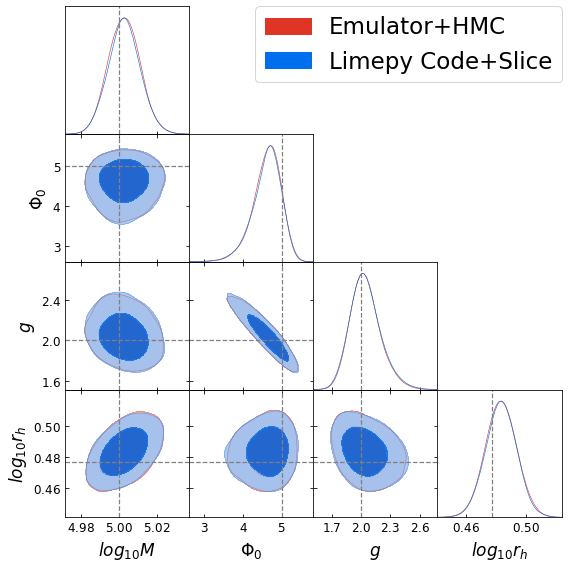

In [10]:
m = plots.GetDistPlotSettings()
m.legend_fontsize = 26
m.axes_labelsize = 20
#m.line_labels =False
m.axis_marker_lw = 1.25
m.axes_fontsize = 15

g = plots.get_subplot_plotter(settings=m)
g.triangle_plot([samples_interp,samples_limepy],filled=True,\
                markers={"g": ip[1], "Phi0": ip[0], "log10M": ip[2], "log10rh": np.log10(ip[3])},\
               legend_labels=['Emulator+HMC','Limepy Code+Slice'],legend_loc='upper right')

In [ ]:
#g.export(fname='../plot/simple_Bayesian_200.pdf')